In [0]:
# !pip uninstall tensorflow -y
# !pip install tensorflow==2.1

In [2]:
# Run this one if using google colab
from google.colab import drive
import sys
import os

drive.mount('/content/gdrive')
sys.path.append("/content/xray_code/python_code")

if not os.path.exists("/content/xray_code"):
  !cp -r "/content/gdrive/My Drive/xray_code/" "/content/xray_code"

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [13]:
%load_ext autoreload
%autoreload 2

from utils import *
from ml_utils import XrayTF
from tqdm import tqdm_notebook as tqdm
from threading import Thread
from constants import LOCAL_IMAGES_LOCATION

import urllib.request as req
import matplotlib.pyplot as plt
import numpy as np
import time

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Load csv if exist, if not get the original one and parse it


In [14]:
csv_file = "normalized_xray_without_full_path.csv"
csv_file_full_path = f'/content/gdrive/My Drive/xray_code/sheet/{csv_file}'

IMAGE_SIZE = 1012
BATCH_SIZE = 32
EPOCH = 10
LABEL_QUOTA= 5000

pd.set_option('display.max_colwidth', -1)


# take existing if it exist
if os.path.exists(csv_file_full_path):
    df = pd.read_csv(csv_file_full_path)
    xray_class = XrayTF(df, IMAGE_SIZE, BATCH_SIZE)
    xray_class.prepend_image_full_path()
else:
    df = get_data_sheet()
    df = normalize_data_frame(df)
    xray_class = XrayTF(df, IMAGE_SIZE, BATCH_SIZE)
    xray_class.prepend_image_full_path()
    xray_class.df.to_csv(csv_file_full_path, index=False)

xray_class.df.head()

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:9: FutureWarning: Passing a negative integer is deprecated in version 1.0 and will not be supported in future version. Instead, use None to not limit the column width.
  if __name__ == '__main__':


,Image Index,labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,image_width,image_width.1,x_pixel_spacing,y_pixel_spacing
0,https://xrayimages.nyc3.digitaloceanspaces.com/v0.1/00000001_000.png,Cardiomegaly,0,1,58,M,PA,2682,2749,0.143,0.143
1,https://xrayimages.nyc3.digitaloceanspaces.com/v0.1/00000002_000.png,No Finding,0,2,81,M,PA,2500,2048,0.171,0.171
2,https://xrayimages.nyc3.digitaloceanspaces.com/v0.1/00000003_000.png,Hernia,0,3,81,F,PA,2582,2991,0.143,0.143
3,https://xrayimages.nyc3.digitaloceanspaces.com/v0.1/00000003_001.png,Hernia,1,3,74,F,PA,2500,2048,0.168,0.168
4,https://xrayimages.nyc3.digitaloceanspaces.com/v0.1/00000003_002.png,Hernia,2,3,75,F,PA,2048,2500,0.168,0.168


# Balance and Analyze
- Balancing would be based on LABEL_QUOTA
- it will delete diseases(rows) in labels(column) where count < LABEL_QUOTA 
- Analyze data before splitting to test and train

In [15]:
# let's balance the data
xray_class.prune_based_on_quota(LABEL_QUOTA)
xray_class.balance_all_labels()

# Verify how balanced our data is
print(xray_class.df.labels.value_counts())
print(xray_class.df["Patient Gender"].value_counts())
print(xray_class.df["View Position"].value_counts())

Infiltration    5302
Pneumothorax    5302
Nodule          5302
Effusion        5302
Atelectasis     5302
Mass            5302
No Finding      5302
Name: labels, dtype: int64
M    21292
F    15822
Name: Patient Gender, dtype: int64
PA    21274
AP    15840
Name: View Position, dtype: int64


(0.0, 100.0)

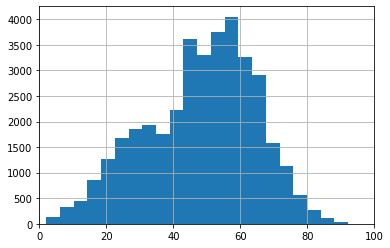

In [16]:
xray_class.df["Patient Age"].hist(bins=100).set_xlim(0,100)

# Download our data
- Parallel download from digital ocean
- prepend system path after download

In [0]:
!rm -rf /content/images
if not os.path.exists(LOCAL_IMAGES_LOCATION):
  !mkdir /content/images

  class Downloader(Thread):
    def __init__(self, file_url, save_path):
        Thread.__init__(self)
        self.file_url = file_url
        self.save_path = save_path

    def run(self):
        remaining_download_tries = 15

        while remaining_download_tries > 0:
            try:
                req.urlretrieve(self.file_url, self.save_path)
                time.sleep(0.1)
            except:
                print("error downloading " + self.file_url +
                      " on trial no: " + str(16 - remaining_download_tries))
                remaining_download_tries = remaining_download_tries - 1
                continue
            else:
                break

  xray_class.df["Image Index"].apply(lambda x: Downloader(x, LOCAL_IMAGES_LOCATION + x.split('/')[-1] ).start() )

In [20]:
#  let's now append the full system path
xray_class.df["Image Index"] = xray_class.df["Image Index"].apply(lambda x : "/content/images/" + x.split('/')[-1])
xray_class.df.head()

,Image Index,labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,image_width,image_width.1,x_pixel_spacing,y_pixel_spacing
36589,/content/images/00011237_028.png,No Finding,28,11237,56,F,AP,2500,2048,0.168000,0.168000
43874,/content/images/00013269_000.png,No Finding,0,13269,50,M,PA,2686,2991,0.143000,0.143000
28775,/content/images/00008911_000.png,No Finding,0,8911,63,M,AP,2500,2048,0.168000,0.168000
4959,/content/images/00001610_000.png,No Finding,0,1610,20,F,PA,2021,1552,0.194311,0.194311
56440,/content/images/00016918_016.png,No Finding,16,16918,64,M,AP,2500,2048,0.168000,0.168000


# Pre-processing of images and label
- split dataframe accordingly with equal numbers of labels in test and train
- batches image
- show image

In [21]:
# Split them into training and validation using NUM_IMAGES 
train_df, valid_df, test_df = xray_class.get_test_train_split_data(len(xray_class.df))

print(train_df.labels.value_counts())
print("="*50)
print(valid_df.labels.value_counts())
print("="*50)
print(test_df.labels.value_counts())

Infiltration    4242
Nodule          4242
Effusion        4242
Atelectasis     4242
Pneumothorax    4241
Mass            4241
No Finding      4241
Name: labels, dtype: int64
Atelectasis     863
Mass            855
Pneumothorax    855
Effusion        845
No Finding      842
Infiltration    841
Nodule          837
Name: labels, dtype: int64
Nodule          223
No Finding      219
Infiltration    219
Effusion        215
Mass            206
Pneumothorax    206
Atelectasis     197
Name: labels, dtype: int64


In [22]:
# Create training and validation data batches using ImageDataGenerator
train_data  = xray_class.generate_image(train_df)
val_data    = xray_class.generate_image(valid_df)
test_data   = xray_class.generate_image(test_df)

Found 29691 validated image filenames belonging to 7 classes.
Found 5938 validated image filenames belonging to 7 classes.
Found 1485 validated image filenames belonging to 7 classes.


# Processing part
- Show images
- Train model 
- Save model

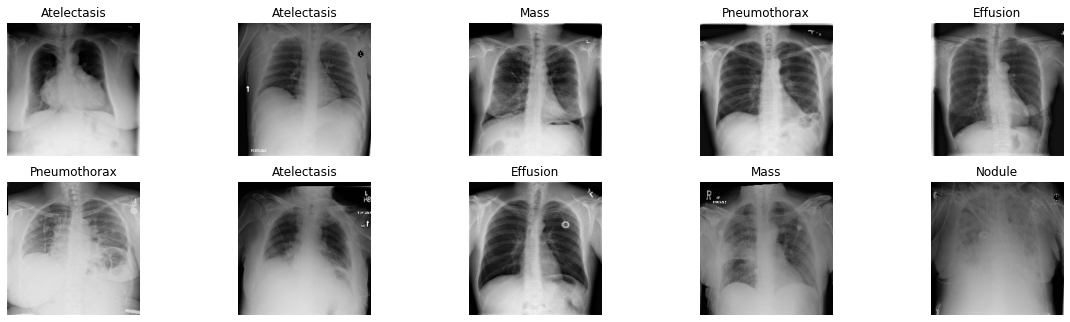

In [23]:
train_images, train_labels = next(train_data)
xray_class.show_25_images(train_images, train_labels)

In [0]:
if xray_class.model_exist("ALL"):
    model = xray_class.model_exist("ALL")
    a, b = model.evaluate(test_data)
else:
    model, stop = xray_class.train_model(100, train_data, val_data)
    a, b = model.evaluate(test_data)

    filename= f"ALL_{b:.2f}"
    xray_class.save_model(model, filename)

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
keras_layer_3 (KerasLayer)   (None, 1001)              55875273  
_________________________________________________________________
dense_9 (Dense)              (None, 512)               513024    
_________________________________________________________________
dropout_6 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_10 (Dense)             (None, 512)               262656    
_________________________________________________________________
dropout_7 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_11 (Dense)             (None, 7)                 3591      
Total params: 56,654,544
Trainable params: 779,271
Non-trainable params: 55,875,273
____________________________________

  ...
    to  
  ['...']


  ...
    to  
  ['...']


  ...
    to  
  ['...']


Train for 928 steps, validate for 186 steps
Epoch 1/100
  1/928 [..............................] - ETA: 54:32WARNING:tensorflow:Early stopping conditioned on metric `loss` which is not available. Available metrics are: 


In [0]:
acc = model.history.history['accuracy']
val_acc = model.history.history['val_accuracy']

loss=model.history.history['loss']
val_loss=model.history.history['val_loss']

epochs_range = range(stop.stopped_epoch + 1)

plt.figure(figsize=(16, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

# Post processing
- Predict our validation data
- load tensorboard
- Show images and percentage of accuracy for those prediction

In [0]:
# Make predictions on the validation data (not used to train on)
predictions = model.predict(val_data, verbose=1) # verbose shows us how long there is to go

In [0]:
# Let's check a few predictions and their different values
val_images, val_labels = next(val_data)

i_multiplier = 0
num_rows = 5
num_cols = 3
num_images = num_rows*num_cols
plt.figure(figsize=(5*2*num_cols, 5*num_rows))
for i in range(num_images):
  plt.subplot(num_rows, 2*num_cols, 2*i+1)
  xray_class.plot_pred(prediction_probabilities=predictions,
            labels=val_labels,
            images=val_images,
            n=i+i_multiplier)
  plt.subplot(num_rows, 2*num_cols, 2*i+2)
  xray_class.plot_pred_conf(prediction_probabilities=predictions,
                labels=val_labels,
                n=i+i_multiplier)
plt.tight_layout(h_pad=1.0)
plt.show()

# Evaluating our model
- classification report
- loss and accuracy

In [0]:
acc = round(b,2)
loss = round(a,2)
print(f"Loss : {loss}, Accuracy: {acc}")

In [0]:
y_test = [xray_class.get_label(x) for x in predictions]
y_val = [xray_class.get_unique_labels()[x] for x in val_data.labels]

xray_class.generate_classification_report(y_test, y_val)